<a href="https://colab.research.google.com/github/s183796/AIStudentProjects/blob/christine/UNet_with_batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn.functional import softmax
import PIL.Image
import os
import torchvision
import cv2

from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
import glob

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [78]:
class UNet(nn.Module): #from https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 1x128x128
        self.e11 = nn.Conv2d(1, 64, kernel_size=3,padding=1)
        self.bn11 = nn.BatchNorm2d(64) # batch normalization
        self.e12 = nn.Conv2d(64, 64, kernel_size=3,padding=1)
        self.bn12 = nn.BatchNorm2d(64) # batch normalization
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #64x64x64

        self.e21 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.bn21 = nn.BatchNorm2d(128) # batch normalization
        self.e22 = nn.Conv2d(128, 128, kernel_size=3,padding=1)
        self.bn22 = nn.BatchNorm2d(128) # batch normalization
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #32x32x128

        self.e31 = nn.Conv2d(128, 256, kernel_size=3,padding=1)
        self.bn31 = nn.BatchNorm2d(256) # batch normalization
        self.e32 = nn.Conv2d(256, 256, kernel_size=3,padding=1)
        self.bn32 = nn.BatchNorm2d(256) # batch normalization
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #16x16x256

        self.e41 = nn.Conv2d(256, 512, kernel_size=3,padding=1)
        self.bn41 = nn.BatchNorm2d(512) # batch normalization
        self.e42 = nn.Conv2d(512, 512, kernel_size=3,padding=1)
        self.bn42 = nn.BatchNorm2d(512) # batch normalization
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #8x8x512

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3,padding=1)
        self.bn51 = nn.BatchNorm2d(1024) # batch normalization
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3,padding=1)
        self.bn52 = nn.BatchNorm2d(1024) # batch normalization

        self.dropout = nn.Dropout(0.5)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #16x16x1024
        self.d11 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
        self.d12 = nn.Conv2d(512,512,kernel_size=3,padding=1)

        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2) #
        self.d21 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.d22 = nn.Conv2d(256,256,kernel_size=3,padding=1)

        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.d31 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.d32 = nn.Conv2d(128,128,kernel_size=3,padding=1)

        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.d41 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.d42 = nn.Conv2d(64,64,kernel_size=3,padding=1)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.bn11(self.e11(x)))
        xe12 = F.relu(self.bn12(self.e12(xe11)))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.bn21(self.e21(xp1)))
        xe22 = F.relu(self.bn22(self.e22(xe21)))
        xp2 = self.pool2(xe22)

        xp2 = self.dropout(xp2) # dropout
        xe31 = F.relu(self.bn31(self.e31(xp2)))
        xe32 = F.relu(self.bn32(self.e32(xe31)))
        xp3 = self.pool3(xe32)

        xp3 = self.dropout(xp3) # dropout
        xe41 = F.relu(self.bn41(self.e41(xp3)))
        xe42 = F.relu(self.bn42(self.e42(xe41)))
        xp4 = self.pool4(xe42)

        xp4 = self.dropout(xp4) # dropout
        xe51 = F.relu(self.bn51(self.e51(xp4)))
        xe52 = F.relu(self.bn52(self.e52(xe51)))

        # Up-convolutions
        xup1 = self.upconv1(xe52)
        xup1 = self.dropout(xup1) # dropout
        xcat = torch.cat([xup1, xe42], dim=1)

        xup21 = F.relu(self.d11(xcat))
        xup22 = F.relu(self.d12(xup21))

        xup2 = self.upconv2(xup22)
        xup2 = self.dropout(xup2) # dropout
        #xcat2 = torch.cat([xup2, xe32[:,:,:-1,:-1]], dim=1)
        xcat2 = torch.cat([xup2, xe32], dim=1)


        xup31 = F.relu(self.d21(xcat2))
        xup32 = F.relu(self.d22(xup31))
        xup3 = self.upconv3(xup32)
        xcat3 = torch.cat([xup3, xe22], dim=1)

        xup41 = F.relu(self.d31(xcat3))
        xup42 = F.relu(self.d32(xup41))

        xup4 = self.upconv4(xup42)
        #xcat4 = torch.cat([xup4, xe12[:,:,2:-3,2:-3]], dim=1)
        xcat4 = torch.cat([xup4, xe12], dim=1)
        xup51 = F.relu(self.d41(xcat4))
        xup52 = F.relu(self.d42(xup51))

        out = self.outconv(xup52)

        output = softmax(out,dim=1)

        return output

# Batch normalization implemented using: https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201
# Dropout implemented according to the MCD Unet here: https://nchlis.github.io/2019_10_30/page.html

In [79]:

net=UNet(n_class=3) #running model

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),  #  mean=0.5 and sigma=0.5
    ]
)

#image=cv2.imread('SOCprist0001.tiff',cv2.IMREAD_GRAYSCALE)

#print(net(transform(image[0:128,0:128])))

In [80]:
#Setting up hyper parameters, from exercise week 6

LEARNING_RATE = 0.001
loss_fn =  nn.CrossEntropyLoss()         # <-- Your code here.
#loss_fn =  nn.BCEWithLogitsLoss()         # <-- Your code here.

def accuracy(ys, ts):
    correct_prediction = torch.eq(ys, ts)
    return torch.mean(correct_prediction.float())




In [94]:
class SOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'data/')
        self.label_folder = os.path.join(root_dir, 'labels/')
        self.transform = transform

        self.image_filenames = sorted([f for f in os.listdir(self.image_folder) if f.endswith('.tiff')])[:200]
        self.label_filenames = sorted([f for f in os.listdir(self.label_folder) if f.endswith('.tif')])[:200]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
      img_name = os.path.join(self.image_folder, self.image_filenames[idx])
      #label_name = os.path.join(self.label_folder, self.label_filenames[idx])
      #assert img_name[-8:-5] != label_name[-7:-4], f"Not corresponding label and image {img_name[-8:-5]}, {label_name[-7:-4]}"

      number1=img_name[-8:-5]
      label_name=os.path.join(self.label_folder,'slice__'+str(number1)+'.tif')

      image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)


      if self.transform:
          image = self.transform(image)

      i, j, h, w = transforms.RandomCrop.get_params(torch.zeros_like(image),output_size=(128,128))
      image = image[:,i:i+h, j:j+w]

      label=label[i:i+h, j:j+w]


      return image, label

In [95]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),  # subtract 0.5 and divide by 0.5
    ]
)


In [96]:
SOC_dataset = SOCDataset(root_dir='drive/My Drive/02456_Deep_Learning/AI data/', transform = transform)


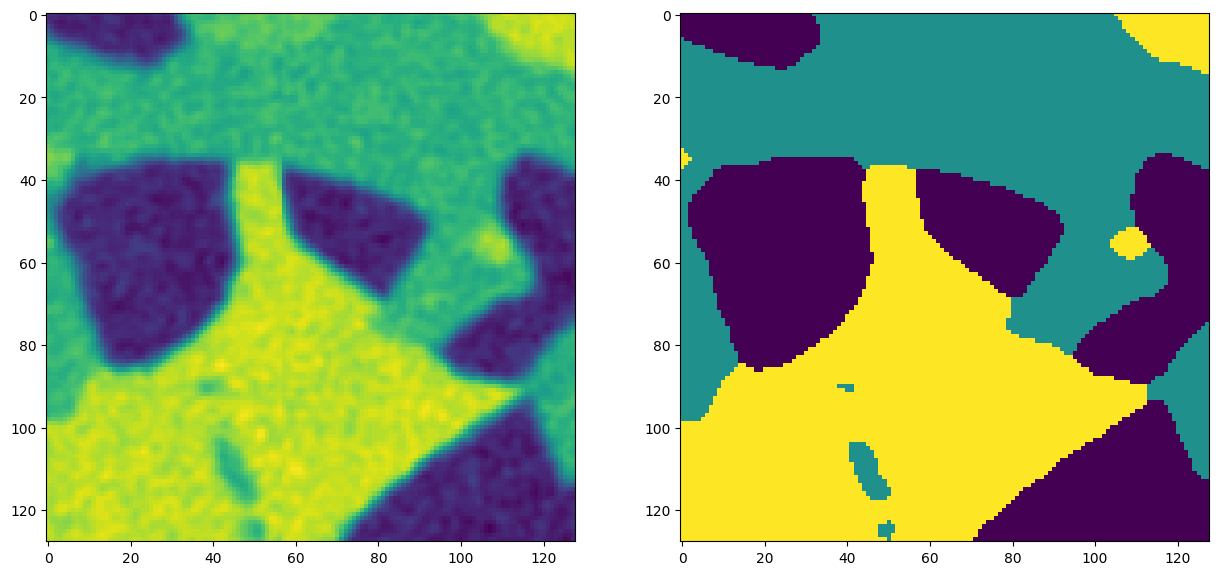

In [97]:
image,label=SOC_dataset[32]

fig,axs=plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(image[0,:,:])
axs[1].imshow(label)


In [98]:
#!pip install torchmetrics

In [99]:
from torchmetrics.classification import JaccardIndex

In [100]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.3
BATCH_SIZE = 16
SEED = 42

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices = train_test_split(
    range(len(SOC_dataset)),
    test_size=TEST_SIZE,
    random_state=SEED
)

val_indices, test_indices = train_test_split(
    test_indices,
    test_size=0.5,
    random_state=SEED
)

# generate subset based on indices
train_split = Subset(SOC_dataset, train_indices)
test_split = Subset(SOC_dataset, test_indices)
val_split = Subset(SOC_dataset, val_indices)

# create batches
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE)

In [101]:
net=UNet(n_class=3)

from torchmetrics.functional.classification import dice
from torchmetrics.classification import MulticlassAccuracy
#metric=Dice(num_classes=3)


optimizer = optim.Adam(net.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

jaccard=JaccardIndex(task="multiclass", num_classes=3).to(device)
accuracy=MulticlassAccuracy(num_classes=3).to(device)
batch_size = 16
num_epochs = 25 #changing the num_epochs from 2 to 12
validation_every_steps = 10

step = 0
net.train()

train_accuracies_jaccard = []
train_accuracies_dice = []
train_accuracies_pixel = []
valid_accuracies_jaccard = []
valid_accuracies_dice = []
valid_accuracies_pixel = []

for epoch in range(num_epochs):

    train_accuracies_batches_jaccard = []
    train_accuracies_batches_dice = []
    train_accuracies_batches_pixel = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        # Forward pass.
        output = net(inputs)

        un_target=targets.unique()
        # Compute loss.
        targets[targets==un_target[0]]=0
        targets[targets==un_target[1]]=1
        targets[targets==un_target[2]]=2

        targets = targets.to(torch.int64)

        loss = loss_fn(output, targets)

        # Clean up gradients from the model.
        optimizer.zero_grad()

        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()

        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = torch.argmax(output,dim=1)
        train_accuracies_batches_dice.append(dice(predictions,targets).cpu())
        train_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
        train_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies_jaccard.append(np.mean(train_accuracies_batches_jaccard))
            train_accuracies_dice.append(np.mean(train_accuracies_batches_dice))
            train_accuracies_pixel.append(np.mean(train_accuracies_batches_pixel))

            train_accuracies_batches_jaccard = []
            train_accuracies_batches_dice = []
            train_accuracies_batches_pixel = []

            # Compute accuracies on validation set.
            valid_accuracies_batches_jaccard = []
            valid_accuracies_batches_dice = []
            valid_accuracies_batches_pixel = []
            with torch.no_grad():
                net.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = net(inputs)

                    un_target=targets.unique()
                    # Compute loss.
                    targets[targets==un_target[0]]=0
                    targets[targets==un_target[1]]=1
                    targets[targets==un_target[2]]=2

                    targets = targets.to(torch.int64)

                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]
                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches_dice.append(dice(predictions,targets).cpu())
                    valid_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
                    valid_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

                net.train()

            # Append average validation accuracy to list.
            valid_accuracies_jaccard.append(np.sum(valid_accuracies_batches_jaccard) / len(test_loader))
            valid_accuracies_dice.append(np.sum(valid_accuracies_batches_dice) / len(test_loader))
            valid_accuracies_pixel.append(np.sum(valid_accuracies_batches_pixel) / len(test_loader))

            print(f"Step {step:<5}   training accuracy with jaccard: {train_accuracies_jaccard[-1]}")
            print(f"             training accuracy with dice: {train_accuracies_dice[-1]}")
            print(f"             training accuracy with pixel by pixel: {train_accuracies_pixel[-1]}")
            print(f"             test accuracy with jaccard: {valid_accuracies_jaccard[-1]}")
            print(f"             test accuracy with dice: {valid_accuracies_dice[-1]}")
            print(f"             test accuracy with pixel by pixel: {valid_accuracies_pixel[-1]}")


print("Finished training.")

Step 10      training accuracy with jaccard: 0.8988885879516602
             training accuracy with dice: 0.9472389221191406
             training accuracy with pixel by pixel: 0.9505918025970459
             test accuracy with jaccard: 0.35095202922821045
             test accuracy with dice: 0.5942772626876831
             test accuracy with pixel by pixel: 0.5112326741218567
Step 20      training accuracy with jaccard: 0.7677735090255737
             training accuracy with dice: 0.8660144805908203
             training accuracy with pixel by pixel: 0.8881373405456543
             test accuracy with jaccard: 0.4534773826599121
             test accuracy with dice: 0.6716423034667969
             test accuracy with pixel by pixel: 0.5980458855628967
Step 30      training accuracy with jaccard: 0.9209286570549011
             training accuracy with dice: 0.9578399658203125
             training accuracy with pixel by pixel: 0.9645690321922302
             test accuracy with jaccard: 0.

Text(0.5, 1.0, 'Mask')

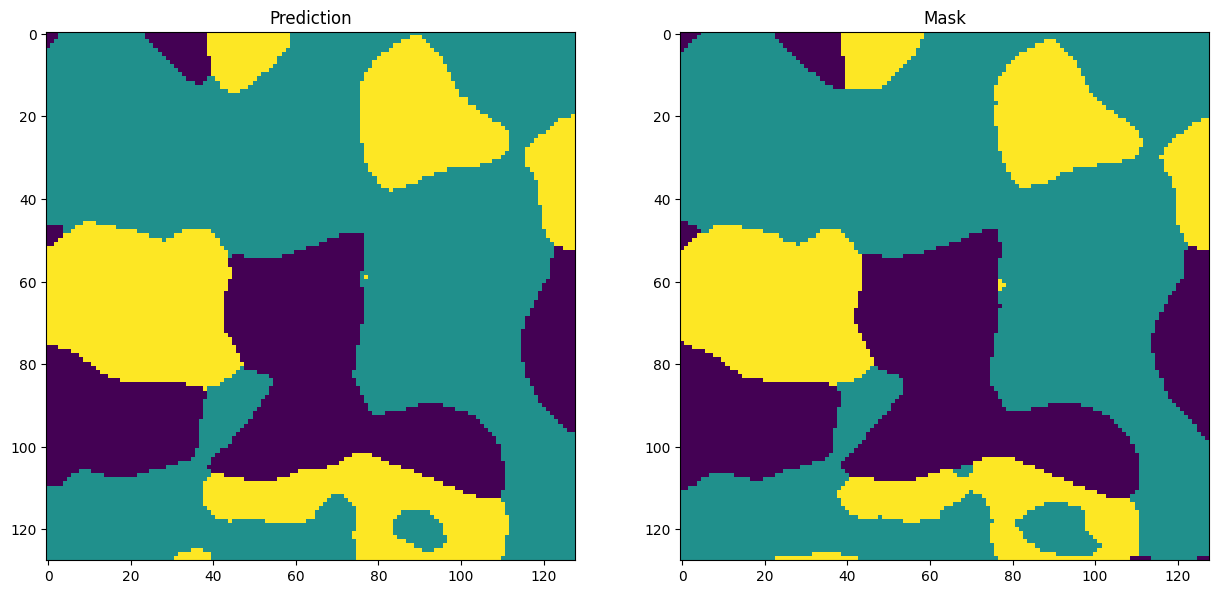

In [102]:
val_acc_dice=[]
val_acc_jaccard=[]
val_acc_pixel=[]

for inputs, targets in val_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  output = net(inputs)
  un_target=targets.unique()
  # Compute loss.
  targets[targets==un_target[0]]=0
  targets[targets==un_target[1]]=1
  targets[targets==un_target[2]]=2

  targets = targets.to(torch.int64)

  predictions = output.max(1)[1]

  val_acc_dice.append(dice(predictions,targets))
  val_acc_jaccard.append(jaccard(predictions,targets))
  val_acc_pixel.append(accuracy(predictions,targets))


fig,axs=plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(predictions[0,:,:].cpu())
axs[0].set_title("Prediction")
axs[1].imshow(targets[0,:,:].cpu())
axs[1].set_title("Mask")




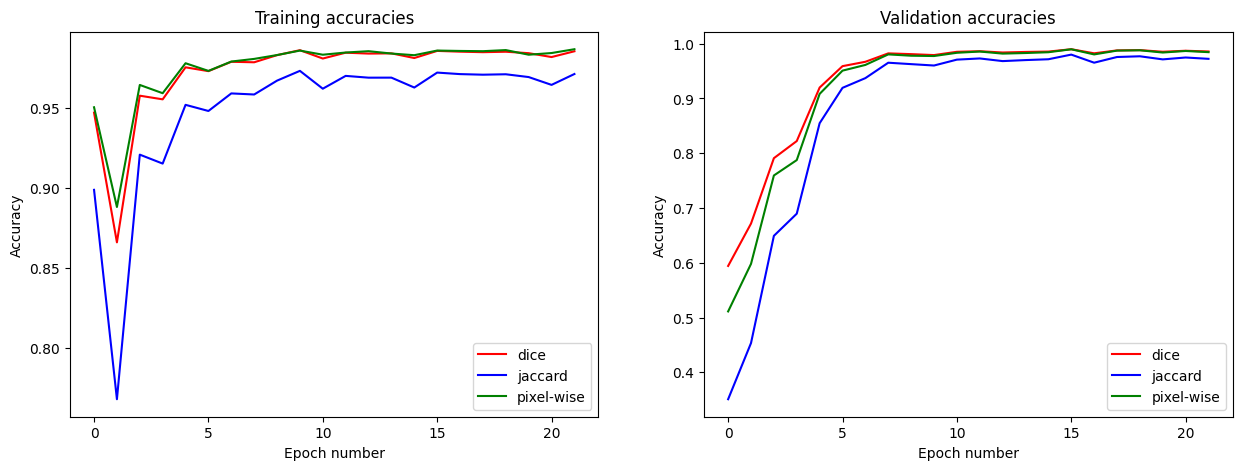

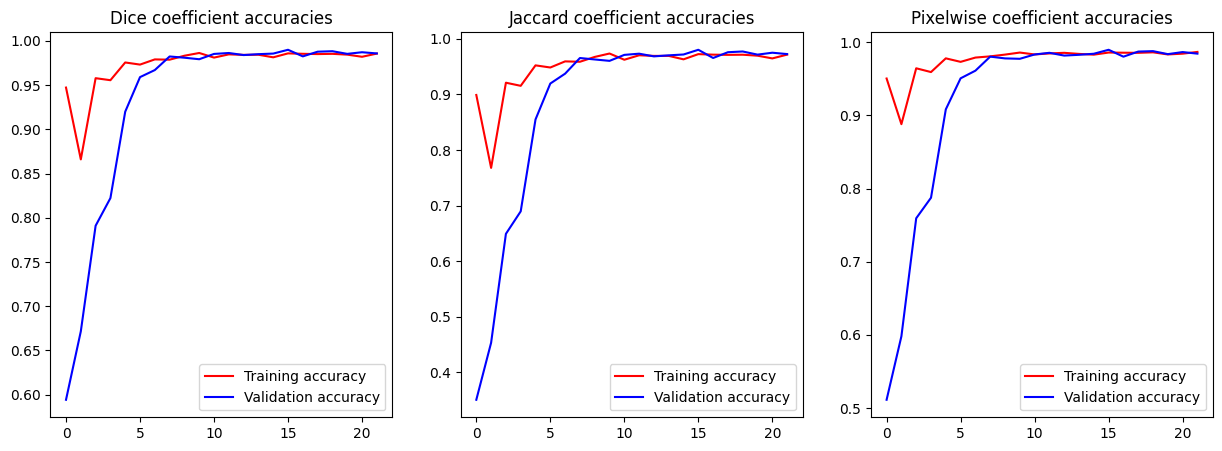

In [103]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
axs[0].plot(train_accuracies_dice,color='red',label='dice')
axs[0].plot(train_accuracies_jaccard,color='blue',label='jaccard')
axs[0].plot(train_accuracies_pixel,color='green',label='pixel-wise')
axs[0].legend()
axs[0].set_title('Training accuracies')
axs[0].set_xlabel('Epoch number')
axs[0].set_ylabel('Accuracy')

axs[1].plot(valid_accuracies_dice,color='red',label='dice')
axs[1].plot(valid_accuracies_jaccard,color='blue',label='jaccard')
axs[1].plot(valid_accuracies_pixel,color='green',label='pixel-wise')
axs[1].legend()
axs[1].set_title('Validation accuracies')
axs[1].set_xlabel('Epoch number')
axs[1].set_ylabel('Accuracy')

fig,axs=plt.subplots(1,3,figsize=(15,5))
axs[0].plot(train_accuracies_dice,color='red',label='Training accuracy')
axs[0].plot(valid_accuracies_dice,color='blue',label='Validation accuracy')
axs[0].set_title('Dice coefficient accuracies')
axs[0].legend()

axs[1].plot(train_accuracies_jaccard,color='red',label='Training accuracy')
axs[1].plot(valid_accuracies_jaccard,color='blue',label='Validation accuracy')
axs[1].set_title('Jaccard coefficient accuracies')
axs[1].legend()

axs[2].plot(train_accuracies_pixel,color='red',label='Training accuracy')
axs[2].plot(valid_accuracies_pixel,color='blue',label='Validation accuracy')
axs[2].set_title('Pixelwise coefficient accuracies')
axs[2].legend()

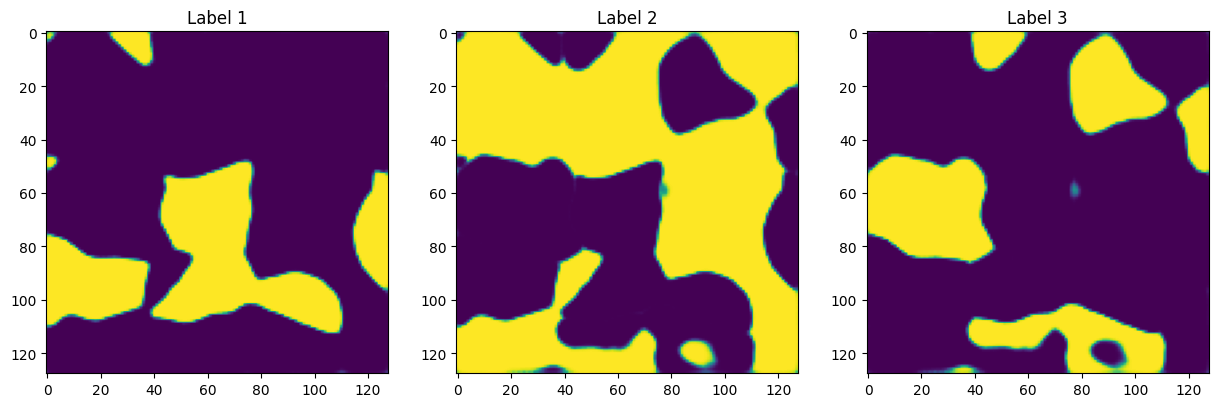

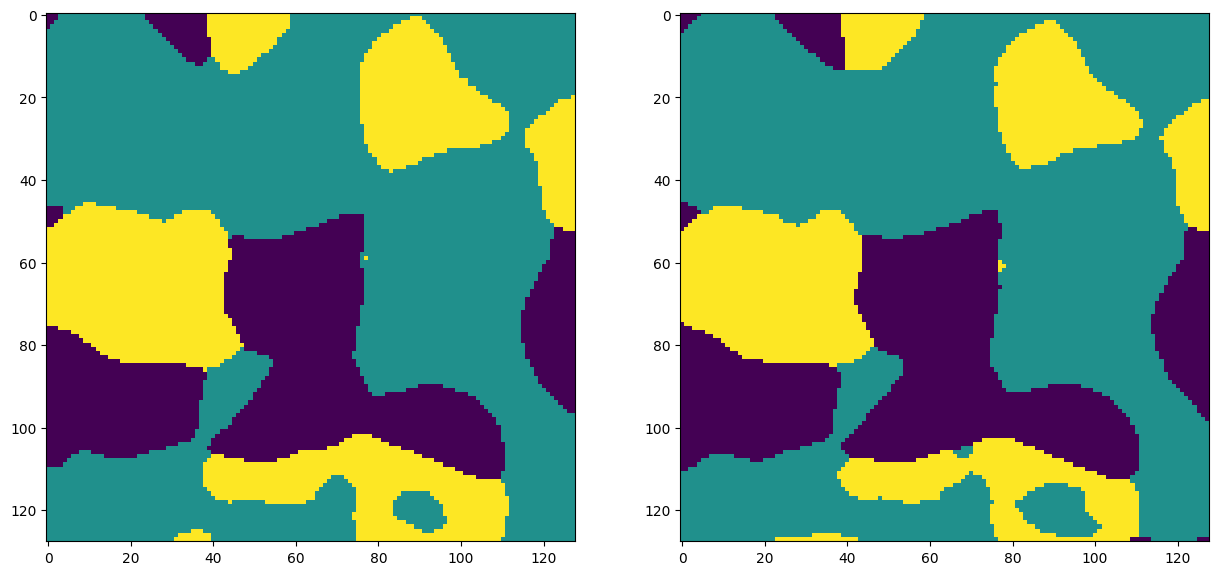

<Figure size 1280x960 with 0 Axes>

In [104]:
fig,axs = plt.subplots(1,3,figsize=(15,15))

axs[0].imshow(output.detach().cpu().numpy()[0,0,:,:])
axs[0].set_title('Label 1')
axs[1].imshow(output.detach().cpu().numpy()[0,1,:,:])
axs[1].set_title('Label 2')
axs[2].imshow(output.detach().cpu().numpy()[0,2,:,:])
axs[2].set_title('Label 3')

# Create a common colorbar
#cax = fig.add_axes([0.93, 0.1, 0.02, 0.8])  # Adjust the position and size of the colorbar

# You can use any of the axes to create the colorbar; here, I've used axs[2]


# Set the label for the colorbar

plt.show()

fig,axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(predictions[0,:,:].cpu())

plt.figure(dpi=200)
axs[1].imshow(targets[0,:,:].cpu())

plt.show()

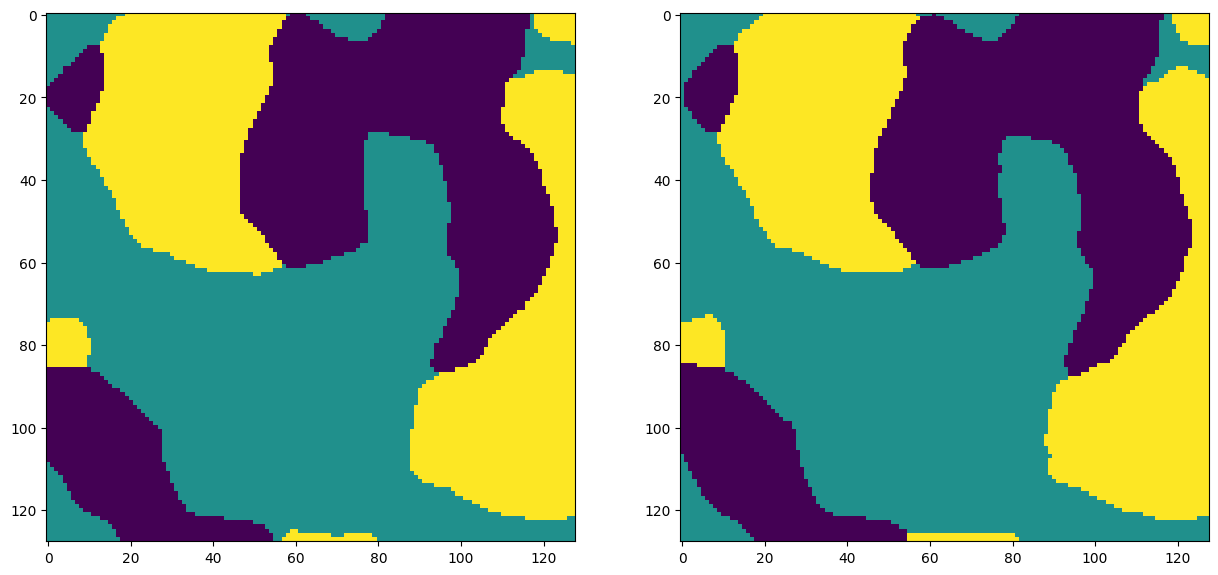

In [105]:
from torchvision.utils import make_grid
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)

outputs = net(inputs)
_, predicted = torch.max(outputs.data, 1)

fig,axs=plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(predicted[0,:,:].cpu())
targets = targets.to(torch.int64) [0,:,:]
axs[1].imshow(targets.cpu())

In [106]:
np.max(output.detach().cpu().numpy()[0,1,:,:])

0.9999999

## Base case



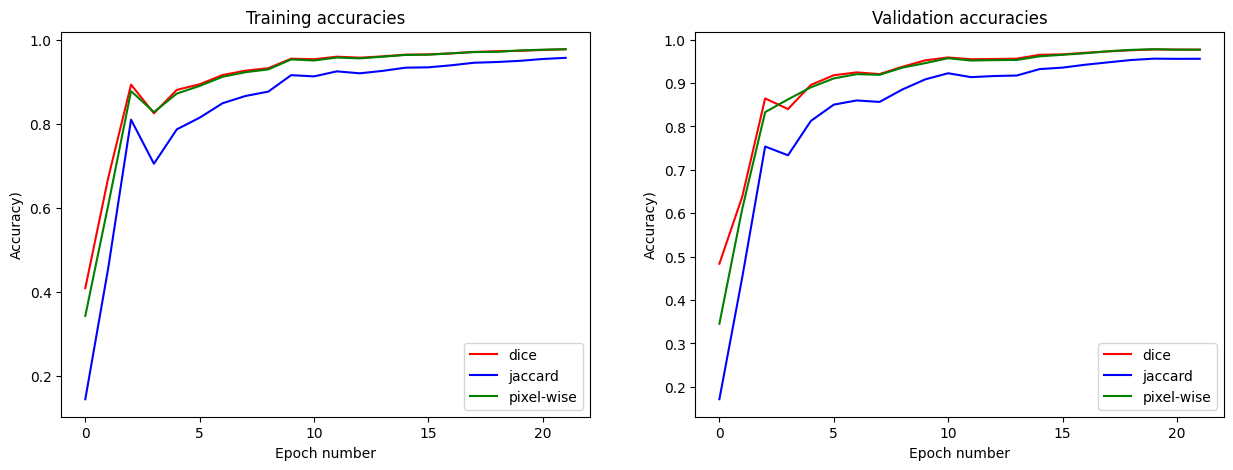

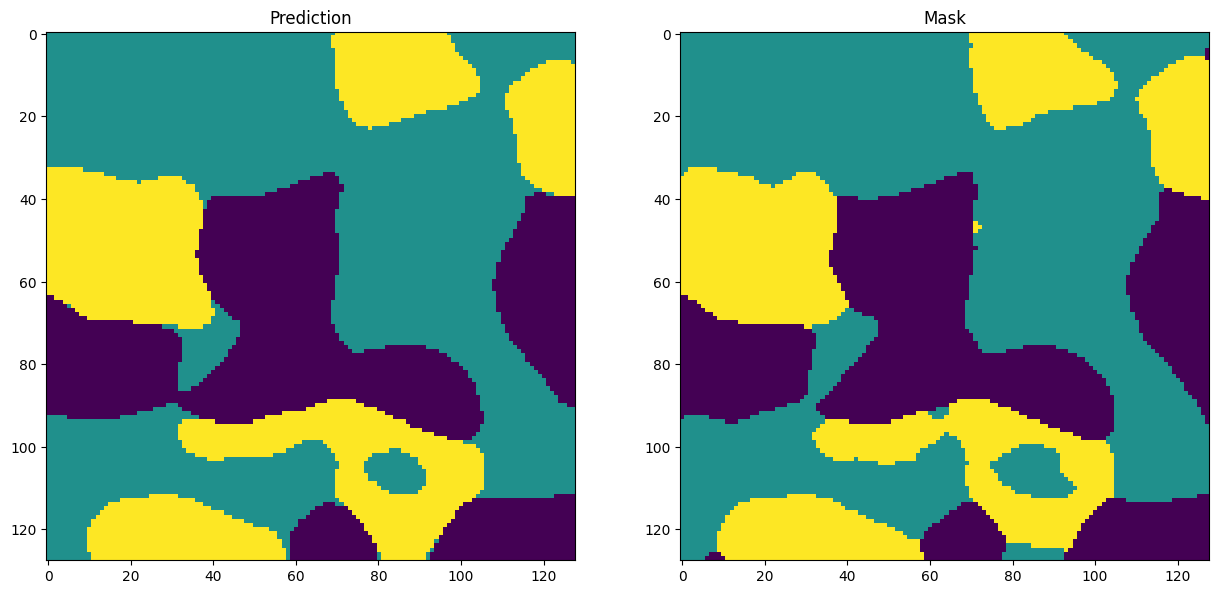

## With batch-norm
The original UNET does not use batch normalization in between the convolution layer and ReLU. Here we insert batch normalization in between them. It helps the network to reduces internal covariance shift and makes the network more stable while training.



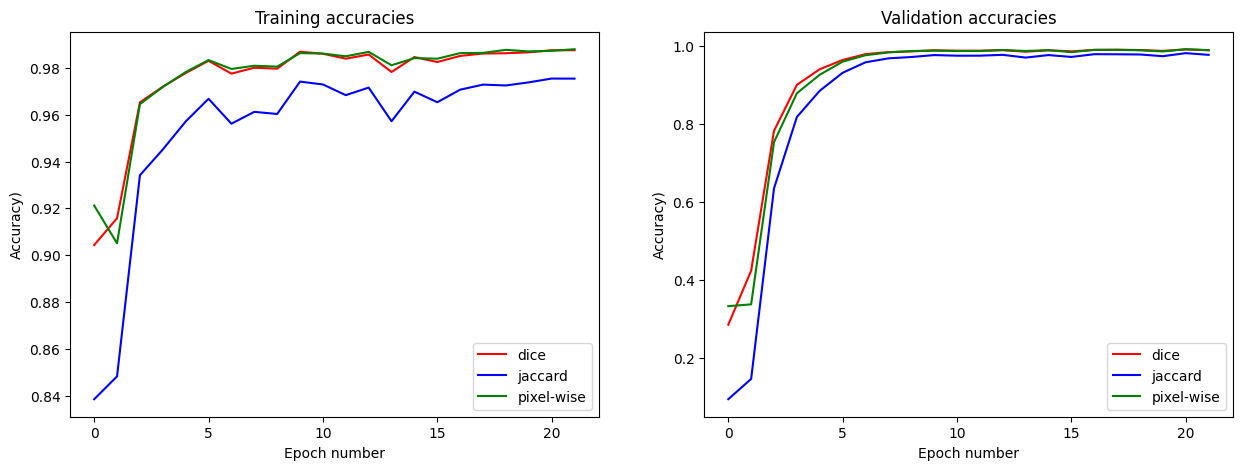

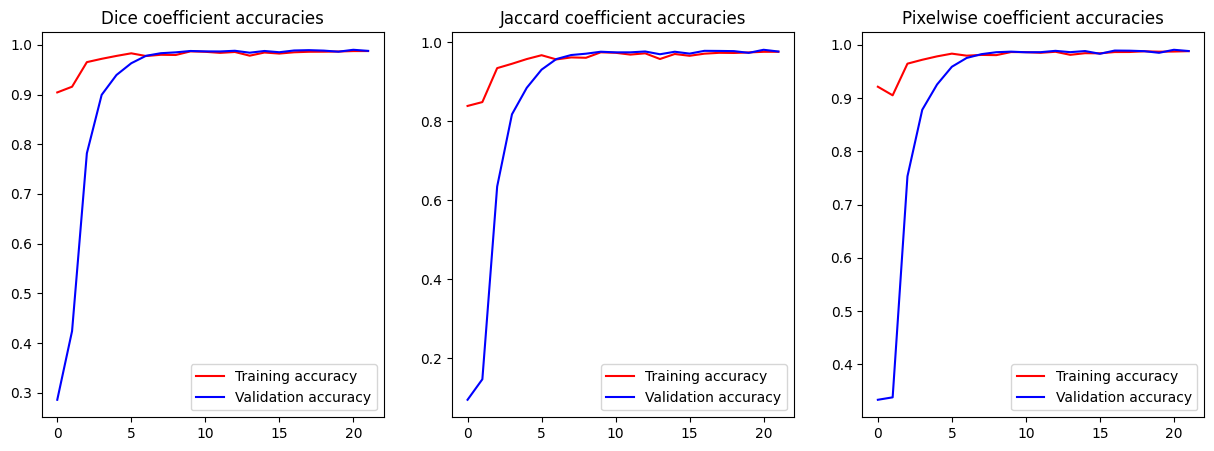

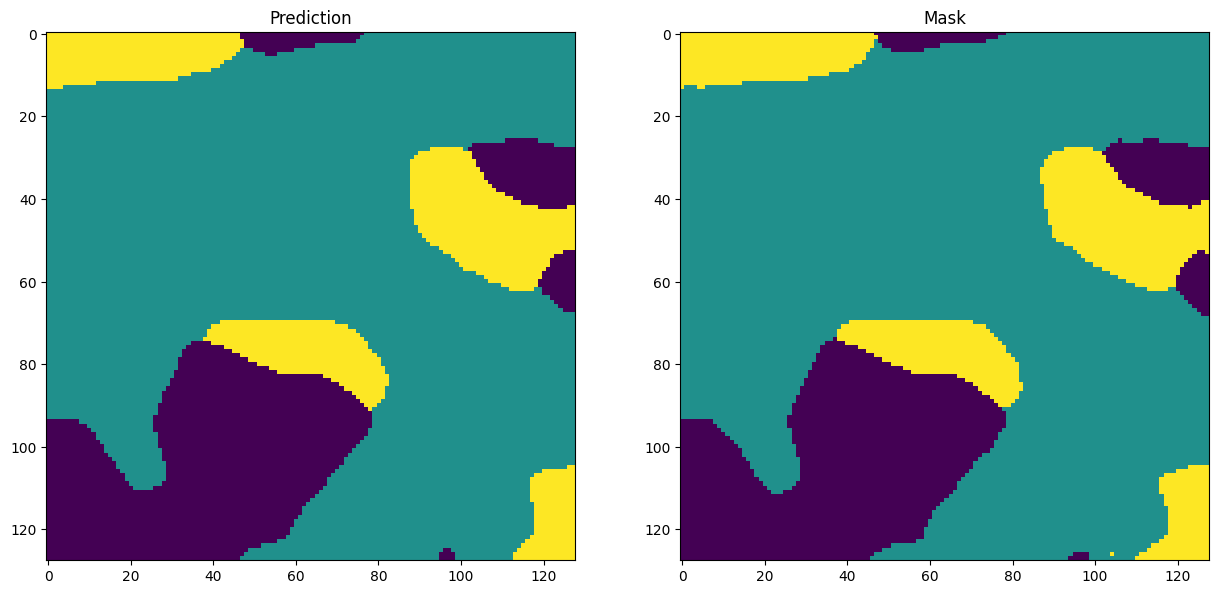

## With Batchnorm and Dropout
Dropout helped to regularize these models, by randomly selecting some layer outputs that are governed by a particular probability (normally it varies between 20% to 50%) that are ”dropped out”. In our context, this means that certain features will not be taken into consideration when segmenting, forcing the model to use other and broader features, making it more robust, and allowing it to generalize better.

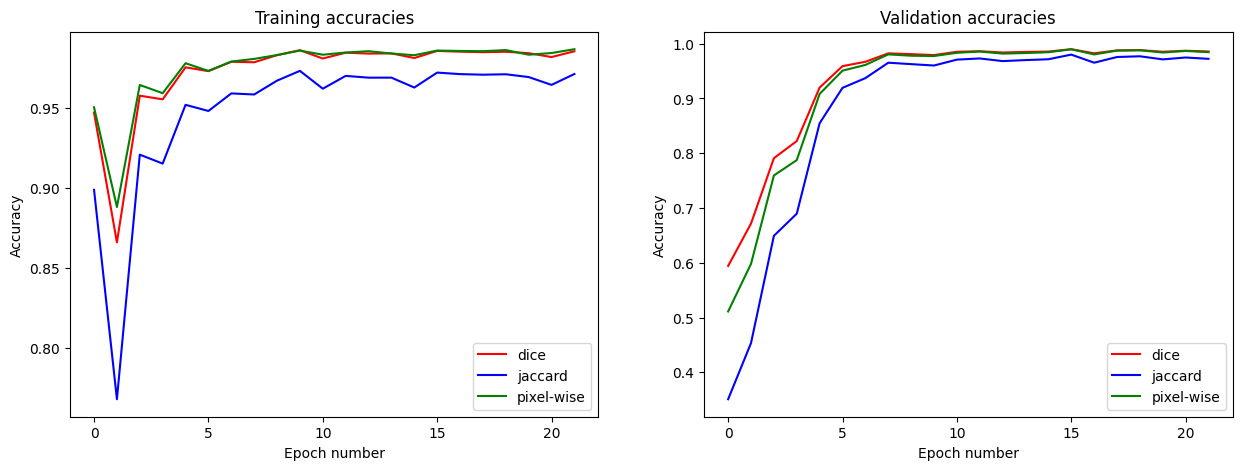

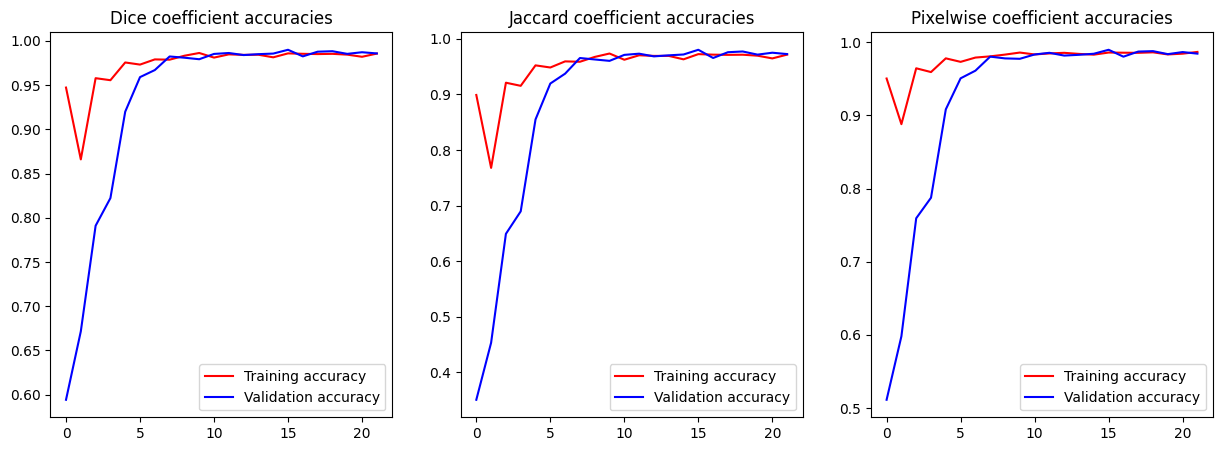

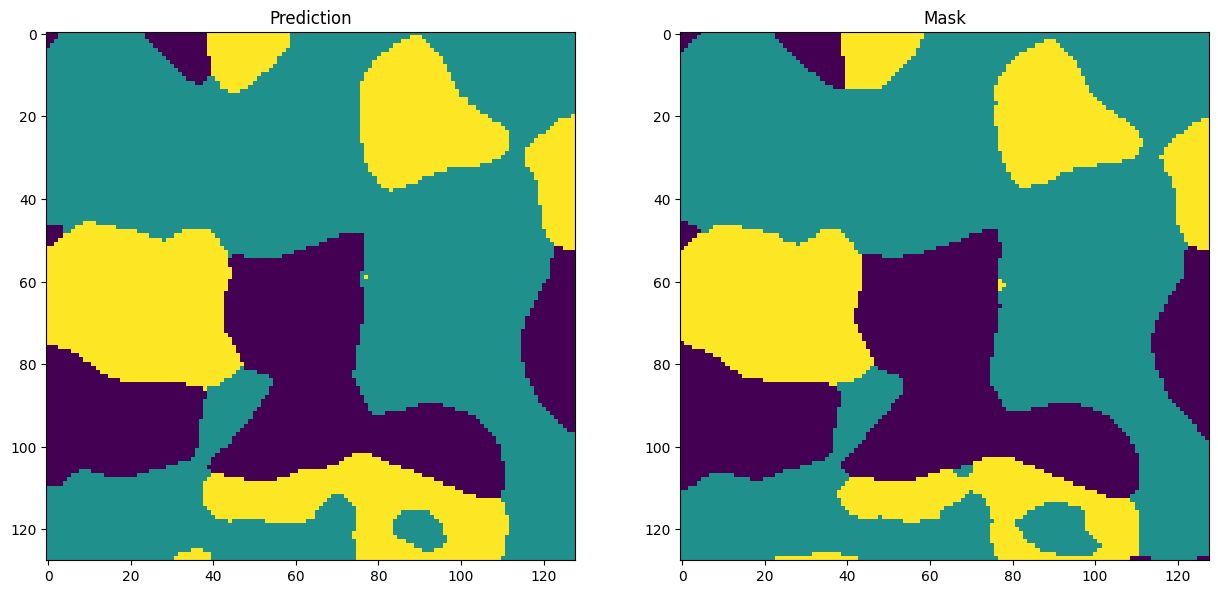

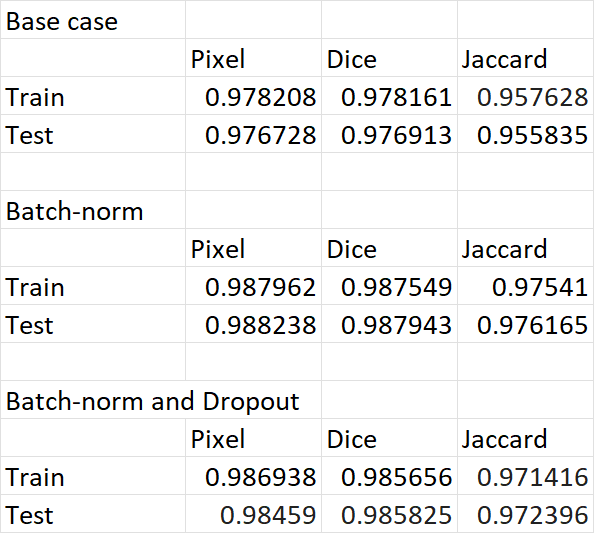